# Machine Learning Trials on the Kaggle House Prices Data Set

by Lukas Tschabold

Link to Kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/

Just a little excercise for me...

## Table of Contents

- [Basic Data Analysis and Preparation](#basic_data_preparation)
    - [Data Import and Sorting of Column Types](#data_import)
    - [Analyse and Prepare Categorical Features](#categorical)
        - [Missing Values](#categorical_missing)
        - [Small Categories](#categorical_small_cats)
    - [Analyse and Prepare Numercial Features](#numerical)
        - [Missing Values](#numerical_missing)
        - [High Zero Counts](#numerical_high_zero)
        - [Outliers](#numerical_outliers)
    - [Analyse and Prepare Count Features](#count)
        - [High Zero Counts, Missing Values](#count_high_zero)
    - [Feature Engineering](#feature_engineering)
    - [Handling Date Features](#date_features)
    - [Final Steps](#final_prep)
- [Model Estimation](#model_estimation)
    - [Preprocessor](#preprocessor)
    - [Lasso Model](#lasso)
    - [XGBoost Regressor](#XGB)
    - [AdaBoost Regressor](#AdaBoost)
    - [Linear Support Vector Regressor](#SVR)
    - [Random Forest](#forest)
    - [K Nearest Neighbors](#KNR)
- [Model Stacking](#model_stacking)
- [Experimental: Fitting a Neuronal Network](#neuronal_network)

In [1]:
####### Imports section ######
import copy
import warnings
import black
import jupyter_black
import pandas as pd
import numpy as np
import tools.tools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from scipy import stats

# Set up black autoformatting in Jupyter
jupyter_black.load(lab=False, target_version=black.TargetVersion.PY39)

## Basic Data Analysis  and Preparation<a class="anchor" id="basic_data_preparation"></a>
### Data Import and Sorting of Column Types <a class="anchor" id="data_import"></a>

As the data originates from a Kaggle competition, there are two data sets 'train' (train.csv) and 'test' (test.csv). 

Note that these do not refer to the train and test data sets that we commonly use for training and testing an estimator: The 'test' data holds *unlabeled* data used for predicting and ranking in the competition whereby the number of uploads per day is limited. Only Kaggle knows the labels of 'test.csv'.

Hence, for locally training and testing an estimator we have to split 'train' into our common train and test sets.

Therefore, during basic data preparation 'train data' will refer to the Kaggle 'train' data set. Likewise, 'test data' will refer to the Kaggle 'test' data. After I am done with basic data preparation and move on to training an estimator, 'train' will be split into X_train, y_train, X_test, and y_test.

The data set comes with a large number of features - 79 in total - which I devide into numerical (continuous), categorical (nominal), count and date features. The train data set contains 1460 observations.

In [2]:
###### Data Import ######
train = pd.read_csv("train.csv", index_col="Id")
test = pd.read_csv("test.csv", index_col="Id")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Alphabetically sort the columns in the data frame
train.sort_index(axis=1, inplace=True)
test.sort_index(axis=1, inplace=True)

# Create backups in memory
train_backup = train.copy()
test_backup = test.copy()

###### Distinguish Column Types ######
# Start with basic division
dtypes = train.dtypes

categorical_cols = dtypes[dtypes == "object"].index.tolist()
numeric_cols = dtypes[dtypes != "object"].index.tolist()

# From the data description, there are some exceptions
additional_categorical_cols = ["MSSubClass", "OverallQual", "OverallCond"]

categorical_cols += additional_categorical_cols

# I treat the ordinal features 'OverallQual' and 'OverallCond' as nominal
for col in additional_categorical_cols:
    train[col] = train[col].astype("str")
    test[col] = test[col].astype("str")

# Additionally, some of the variables are dates or countable
date_cols = ["YearBuilt", "YearRemodAdd", "YrSold", "MoSold", "GarageYrBlt"]

count_cols = [
    "FullBath",
    "HalfBath",
    "GarageCars",
    "Fireplaces",
    "BsmtHalfBath",
    "KitchenAbvGr",
    "BedroomAbvGr",
    "BsmtFullBath",
    "TotRmsAbvGrd",
]

# Update numeric cols list
numeric_cols = list(
    set(numeric_cols)
    - set(additional_categorical_cols)
    - set(date_cols)
    - set(count_cols)
)
# Categorical cols list should be ok

# Don't include the target in the lists
numeric_cols.remove("SalePrice")

# Alphabetically sort the column lists
numeric_cols.sort()
categorical_cols.sort()
count_cols.sort()
date_cols.sort()

Train shape: (1460, 80)
Test shape: (1459, 79)


Note that I decided to add 'OverallQual' and 'OverallCond' to the categorical columns, which here are all treated as nominal. 'OverallQual' and 'OverallCond' originally are *ordinal* integer based features with values ranging from 1 to 10. I decided to treat them as nominal anyway since the same procedure for creating dummies - or target encoding - applies in both cases.

### Analyse and Prepare Categorical Features <a class="anchor" id="categorical"></a>
#### Missing Values <a class="anchor" id="categorical_missing"></a>

Looking at the training data set, many of the categorical features seem to have (lots of) missing values. However, consulting the data description reveals that for a number of the categorical variables the string value 'NA' usually indicates that for the corresponding observations the sold house *itself* does not exhibit the respective feature (e.g. a pool or basement). This issue concerns the following features:

\['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'\]

In these cases NAs can be replaced by the substitute category 'None'.

This sounds easy at first. However, looking at the training data, one problem here is the slight imbalance in the number of missing values in the 'Bsmt' features which indicates the presence of *real* missing values in 'BsmtExposure' and 'BsmntFinType2'. I keep these particular values as missing (see code). The Kaggle test data set shows the same issue additionally with the 'Garage' features. Here I proceed likewise.

Imputation is carried out later on using scikit-learn tools. For the categorical variables, I will use the mode. This should be admissible as the number of missing values after above's corrections is low for all categorical features.

In [3]:
###### Categorical Cols ######
# Helper function
def get_fractions_of_nas(df, cols):
    fractions_of_nas = df[cols].isnull().sum() / len(df)
    # Return only if any NAs present in column:
    fractions_of_nas = fractions_of_nas.loc[fractions_of_nas > 0]
    return fractions_of_nas


# Print the fractions of NAs in train data
fractions_of_nas = get_fractions_of_nas(train, categorical_cols)
print("Categorical features: Fractions of NAs in TRAIN data (if any)", "\n")
print(fractions_of_nas, "\n")

# Create a new category 'None' for 'special NA cols':
# For these features, 'NA' indicates that the house itself does not have the respective feature
# (false NAs)

special_na_cols = [
    "Alley",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature",
]

# Treat false NAs in the TRAIN data set:

# For treating the impalances in 'Bsmt' and 'Garage' features,
# create boolean masks which indicate the presence of a garage or basement.
# I knowingly leave out the numeric 'Bsmt' and 'Garage' features in this process
# (that still is a to-do).

bsmt_cols = [col for col in special_na_cols if col.startswith("Bsmt")]
garage_cols = [col for col in special_na_cols if col.startswith("Garage")]

bsmt_mask = pd.Series(np.full(len(train), False), index=train.index)
garage_mask = bsmt_mask.copy()

for col in bsmt_cols:
    bsmt_mask = bsmt_mask | train[col].notnull()
for col in garage_cols:
    garage_mask = garage_mask | train[col].notnull()


# Helper function
def replace_false_nas(df, cols, mask):
    for col in cols:
        # Only observations with False in mask
        # are candidates for false NAs:
        replace_mask = df[col].isnull() & ~mask
        df.loc[replace_mask, col] = "None"


# Pandas data frames are mutable objects,
# hence, this should do what I want:
replace_false_nas(train, bsmt_cols, bsmt_mask)
replace_false_nas(train, garage_cols, garage_mask)

# Also create the new category 'None' for the remaining 'special NA cols'
tmp_col_list = list(set(special_na_cols) - set(bsmt_cols + garage_cols))
train[tmp_col_list] = train[tmp_col_list].fillna("None")

# Print fractions again
fractions_of_nas = get_fractions_of_nas(train, categorical_cols)
print("\nAfter replacing false NAs:")
print("Categorical features: Fractions of NAs in TRAIN data (if any)", "\n")
print(fractions_of_nas, "\n")

# Treat false NAs in the TEST data set
# -> Follow the same recipe as above

# Update boolean masks
bsmt_mask = pd.Series(np.full(len(test), False), index=test.index)
garage_mask = bsmt_mask.copy()

for col in bsmt_cols:
    bsmt_mask = bsmt_mask | test[col].notnull()
for col in garage_cols:
    garage_mask = garage_mask | test[col].notnull()

# Replace false NAs
replace_false_nas(test, bsmt_cols, bsmt_mask)
replace_false_nas(test, garage_cols, garage_mask)
test[tmp_col_list] = test[tmp_col_list].fillna("None")

# Print fractions of NAs for test data after replacement
fractions_of_nas = get_fractions_of_nas(test, categorical_cols)
print("\nAfter replacing false NAs:")
print("Categorical features: Fractions of NAs in TEST data (if any)", "\n")
print(fractions_of_nas)

Categorical features: Fractions of NAs in TRAIN data (if any) 

Alley           0.937671
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
BsmtQual        0.025342
Electrical      0.000685
Fence           0.807534
FireplaceQu     0.472603
GarageCond      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageType      0.055479
MasVnrType      0.005479
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64 


After replacing false NAs:
Categorical features: Fractions of NAs in TRAIN data (if any) 

BsmtExposure    0.000685
BsmtFinType2    0.000685
Electrical      0.000685
MasVnrType      0.005479
dtype: float64 


After replacing false NAs:
Categorical features: Fractions of NAs in TEST data (if any) 

BsmtCond        0.002056
BsmtExposure    0.001371
BsmtQual        0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
Functional      0.001371
GarageCond      0.001371
GarageFinish    0.001371
GarageQual      0.0

#### Small Categories <a class="anchor" id="categorical_small_cats"></a>

Many of the categorical variables contain very small categories:

In [4]:
# Get and print fractions of smallest category
fractions_of_smallest_category = train[categorical_cols].apply(
    lambda s: (s.value_counts() / len(s)).min()
)

print("Categorical features: Fractions of the smallest category in TRAIN data")
print("Showing the first 15 columns...", "\n")
print(fractions_of_smallest_category.sort_values().head(15))

Categorical features: Fractions of the smallest category in TRAIN data
Showing the first 15 columns... 

Utilities      0.000685
Functional     0.000685
MiscFeature    0.000685
Exterior2nd    0.000685
Exterior1st    0.000685
Heating        0.000685
ExterCond      0.000685
Electrical     0.000685
Condition2     0.000685
OverallCond    0.000685
RoofMatl       0.000685
HeatingQC      0.000685
OverallQual    0.001370
PoolQC         0.001370
RoofStyle      0.001370
dtype: float64


This, of course, can lead to overfitting.

Additionally, some of the variables contain a high number of categories (more than 8) which raises the curse of dimensionality when creating dummies.

In [5]:
# Get and print the number of categories
number_of_categories = train[categorical_cols].nunique().sort_values(ascending=False)
print("Categorical features: Features with many categories in TRAIN data", "\n")
print(number_of_categories.loc[number_of_categories > 8])

Categorical features: Features with many categories in TRAIN data 

Neighborhood    25
Exterior2nd     16
MSSubClass      15
Exterior1st     15
OverallQual     10
SaleType         9
Condition1       9
OverallCond      9
dtype: int64


A widely used approach in such a case is to apply **target encoding** with regularization (following [this paper](https://dl.acm.org/doi/10.1145/507533.507538)) which I will follow here, too. This will be done in the estimation section in concert with the remaining sklearn tools. For that end, I have written my own target encoder which can fill in unknown categories in the test data with the train overall target mean.

### Analyze and Prepare Numerical Features <a class="anchor" id="numerical"></a>
#### Missing values <a class="anchor" id="numerical_missing"></a>

From the numerical features only a few exhibit missing values. As the number of NAs is not substantial here, I will impute these by the mean:

In [6]:
###### Numerical Cols ######
# Print number of missing values
print("Numerical features: Number of missing values in TRAIN data", "\n")
print(train[numeric_cols].isnull().sum())

Numerical features: Number of missing values in TRAIN data 

1stFlrSF           0
2ndFlrSF           0
3SsnPorch          0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
EnclosedPorch      0
GarageArea         0
GrLivArea          0
LotArea            0
LotFrontage      259
LowQualFinSF       0
MasVnrArea         8
MiscVal            0
OpenPorchSF        0
PoolArea           0
ScreenPorch        0
TotalBsmtSF        0
WoodDeckSF         0
dtype: int64


#### High Zero Counts <a class="anchor" id="numerical_hight_zero"></a>

More of an issue is the large share of zeros in some of the numerical columns. Here the zeros indicate that a house in the sample does not have the respective feature (basement, 2nd floor, etc.), which seems to apply to all numercial features that exhibit zero values. 

Note that none of the numeric variables show any negative observations. This comes as expected as most of them hold information about the size of some area in square feet.

In [7]:
# Get and print fractions of zeros
fractions_of_zeros = train[numeric_cols].apply(lambda x: (x == 0).sum() / len(x))
print("Numerical features: Fractions of zeros in TRAIN data", "\n")
print(fractions_of_zeros)

Numerical features: Fractions of zeros in TRAIN data 

1stFlrSF         0.000000
2ndFlrSF         0.567808
3SsnPorch        0.983562
BsmtFinSF1       0.319863
BsmtFinSF2       0.885616
BsmtUnfSF        0.080822
EnclosedPorch    0.857534
GarageArea       0.055479
GrLivArea        0.000000
LotArea          0.000000
LotFrontage      0.000000
LowQualFinSF     0.982192
MasVnrArea       0.589726
MiscVal          0.964384
OpenPorchSF      0.449315
PoolArea         0.995205
ScreenPorch      0.920548
TotalBsmtSF      0.025342
WoodDeckSF       0.521233
dtype: float64


One problem with a large share of zeros is that, when performing standard scaling, the estimates of the variance and mean will be biased. Basically, we should only take the strictly positive values into account as only these give indication about the distribution of the size of a garage or porch, for example.

Additionally, mostly all of the numeric features seem to be approximately log-normally distributed when only examining strictly positive observations. Let's look at two examples:

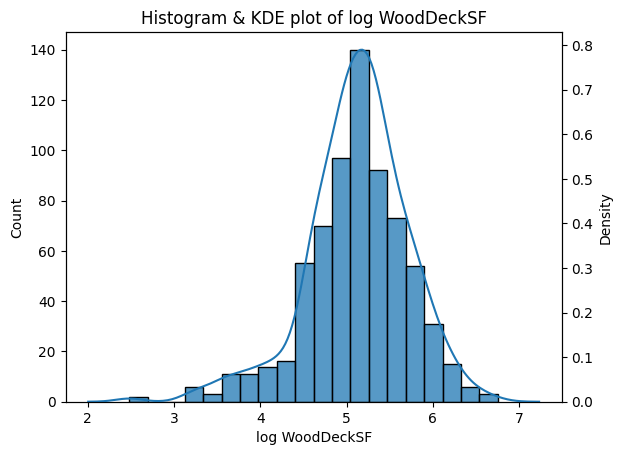

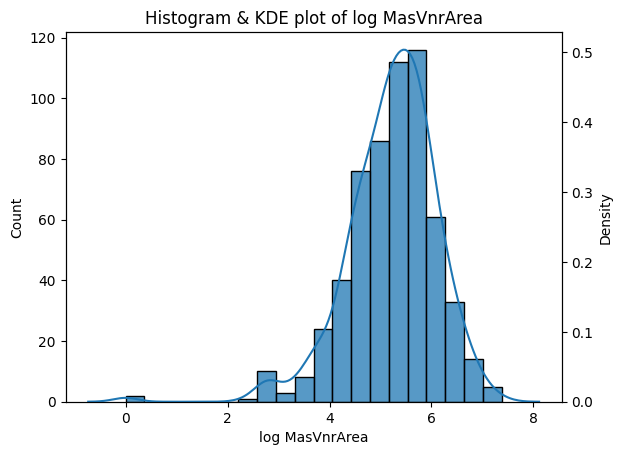

In [8]:
plt.style.use("default")

# Make histrogram and KDE plot of 'WoodDeckSF' and 'MasVnrArea'
# only for the strictly positive observations
tmp_col_list = ["WoodDeckSF", "MasVnrArea"]

for col in tmp_col_list:
    tmp_plot_df = train.loc[train[col] > 0, [col]].copy()
    tmp_plot_df[col] = np.log(tmp_plot_df[col])
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set(xlabel="log " + col)
    sns.histplot(data=tmp_plot_df, x=col, bins=20, ax=ax1)
    sns.kdeplot(data=tmp_plot_df, x=col, ax=ax2).set(
        title="Histogram & KDE plot of log " + col
    )
    plt.show()

del tmp_plot_df

However, up until now I have not found a consistent way to incorporate the implicit information about feature presence into my estimators. For me this is still an area of research and I wished I could somehow split the information flow in a linear estimator such that a feature only exercises influence when it is actually present for this observation ($> 0$). In such a setup I could standard scale only the strictly positive observations using the restricted estimators for the mean and variance.

Until I have found a solution to this, I will stick with sklearn's PowerTransformer which can deal with zero valued observations using the Yeo-Johnson transformations. Hence, I will apply the PowerTransformer to both kind of numerical features, the ones with and without zero values.

#### Outliers <a class="anchor" id="numerical_outliers"></a>

For detecting outliers, instead of an automated I followed a manual, visual approach. As all numerical features only take values $\geq 0$ and seem to be log-normally distributed (at least the strictly positive observations), outlier detection mostly means looking at the largest values of a feature. Hence, for each feature we can, in principle, define the absolute number of largest values that we deem to be outliers. This allows me to play around with these numbers when I am not certain about some observations, and check the influence of these data points on the model's performance.

There are two notable exception to this simple approach, though, as I decided to remove only the second largest observation of 'OpenPorchSF' and additionally the 8th largest observation of 'LotFrontage'. This comes as I proceeded by looking at scatter plots of the numercial features against the target 'SalePrice'.

The following code shows what I came up with. Also I show a scatter plot of 'LotArea' vs. 'SalePrice' as an example.

For some other project I would consider trying out sklearn's IsolationForest. However, I would always take a look at some visualisations in order to make a final decision - given the numer of features is not completely overwhelming.

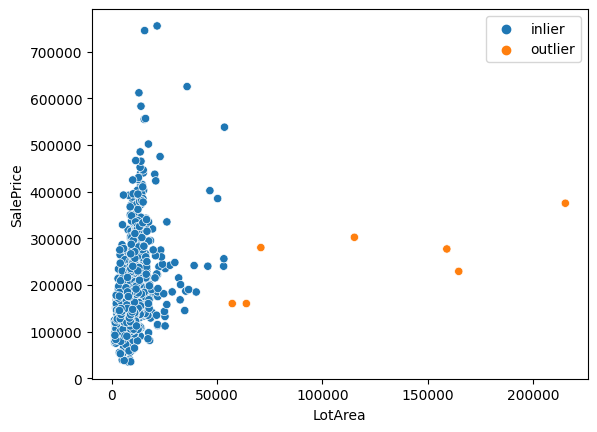

In [9]:
# Plot 'LotArea' against 'SalePrice' and highlight identified outliers
tmp_plot_df = train[["SalePrice", "LotArea"]].copy()
outliers = train["LotArea"].sort_values().iloc[-7:].index
tmp_plot_df["Outlier"] = tmp_plot_df.index.isin(outliers)
tmp_plot_df["Outlier"] = tmp_plot_df["Outlier"].map({True: "outlier", False: "inlier"})
sns.scatterplot(data=tmp_plot_df, x="LotArea", y="SalePrice", hue="Outlier")
plt.legend(title=False)
plt.show()

del tmp_plot_df

# Drop these numbers of largest values
number_of_outliers_to_drop = {
    "1stFlrSF": 1,
    "BsmtFinSF1": 2,
    "GarageArea": 4,
    "GrLivArea": 2,
    "LotArea": 7,
    "LotFrontage": 2,
    "LowQualFinSF": 1,
    "MiscVal": 3,
    "TotalBsmtSF": 1,
}

indexes_to_drop = []

# Special tratment for OpenPorchSF
index_to_drop = train["OpenPorchSF"].dropna().sort_values().index[-2]
indexes_to_drop.append(index_to_drop)

# Special treatment for LotFrontage
index_to_drop = train["LotFrontage"].dropna().sort_values().index[-8]
indexes_to_drop.append(index_to_drop)

# Regular treatment using above's drop dictionary
for col, num in number_of_outliers_to_drop.items():
    sorted_col = train[col].dropna().sort_values()
    indexes_to_drop.extend(sorted_col.index[-num:])

train.drop(indexes_to_drop, axis=0, inplace=True)

### Analyze and Prepare Count Features <a class="anchor" id="count"></a>
#### High Zero Counts, Missing Values <a class="anchor" id="count_high_zero"></a>

Also some of the count features suffer from many zeros. But in contrast to the continuous numercial features, here a zero carries no 'hidden' information. Hence, they should not be a problem.

I decide to impute missing values with the mode and to also apply the PowerTransformer. The train data set does not contain missing values but the test data does.

In [10]:
###### Count cols ######
# Print fractions of zeros in count features
fractions_of_zeros = train[count_cols].apply(lambda x: (x == 0).sum() / len(x))
print("Count features: Fractions of zeros in TRAIN data", "\n")
print(fractions_of_zeros)

Count features: Fractions of zeros in TRAIN data 

BedroomAbvGr    0.004161
BsmtFullBath    0.587379
BsmtHalfBath    0.943828
Fireplaces      0.475035
FullBath        0.006241
GarageCars      0.054092
HalfBath        0.624133
KitchenAbvGr    0.000693
TotRmsAbvGrd    0.000000
dtype: float64


### Feature Engineering <a class="anchor" id="feature_engineering"></a>

I decide to include the age of the house and the garage at time of sale as new (numeric) features. Also I add the time since the last remod to the data set.

Note that 'GarageYrBlt' has some missing values in the train data that will be handed on to the new feature 'GarageAge'. These missing values will be imputed later on.

In [11]:
###### Feature Engineering ######
# Create feature Age
train["Age"] = train["YrSold"] - train["YearBuilt"]
test["Age"] = test["YrSold"] - test["YearBuilt"]

# Create feature GarageAge
train["GarageAge"] = train["YrSold"] - train["GarageYrBlt"]
test["GarageAge"] = test["YrSold"] - test["GarageYrBlt"]

# Create feature RemodAge
train["RemodAge"] = train["YrSold"] - train["YearRemodAdd"]
test["RemodAge"] = test["YrSold"] - test["YearRemodAdd"]

# Update the numeric cols
numeric_cols += ["Age", "GarageAge", "RemodAge"]

### Handling Date Features <a class="anchor" id="date_features"></a>

The date features 'YrSold', 'MoSold' and 'YearBuilt' might actually provide some information on the sale price. For instance, the housing market might have been more tight in some years than in others. Also there might be some fluctuation (seasonality) over the year. And houses built in some years might be of better quality than built in other years (building style).

Hence, I decided to include these particular date features as *cateogrical* features. There are no missing values in the train data set for these features.

While 'YrSold' only encompasses the years of 2007 until 2010, 'YearBuilt' lies within a wide range from 1872 until 2010. For not creating to many categories, I bin 'YearBuilt' into decades.

In [12]:
###### Date Cols ######
# Bin 'YearBuilt' into decades
train["YearBuilt"] = round(train["YearBuilt"], -1)
test["YearBuilt"] = round(test["YearBuilt"], -1)

# Move 'YrSold', 'MoSold' and 'YearBuilt' to the categorical columns
for col in ["YrSold", "MoSold", "YearBuilt"]:
    train[col] = train[col].astype("str")
    test[col] = test[col].astype("str")
    categorical_cols.append(col)
    date_cols.remove(col)

### Final Basic Data Preparation Steps <a class="anchor" id="final_prep"></a>

The following code performs some final data preparation steps including splitting the 'train' data into our common train and test sets. The remaining date columns get dropped from the data.

In [13]:
###### Final Base Preparation ######
# Assure NA value consistency for sklearn
train.fillna(np.nan, inplace=True)
test.fillna(np.nan, inplace=True)

# Split X and y
y = train["SalePrice"].copy()
X = train.drop("SalePrice", axis=1).copy()

# Since the objective is to predict the log of the sale price
y = np.log(y)

# Sort columns again
# Note that the remaining date columns will not be used
numeric_cols.sort()
count_cols.sort()
categorical_cols.sort()

# Only keep the identified columns
all_cols = numeric_cols + count_cols + categorical_cols
X = X[all_cols]
test = test[all_cols]

# Store the column integer indexes
numeric_cols_indexes = [*range(len(numeric_cols))]
count_cols_indexes = [*range(len(numeric_cols), len(numeric_cols + count_cols))]
categorical_cols_indexes = [
    *range(
        len(numeric_cols + count_cols),
        len(numeric_cols + count_cols + categorical_cols),
    )
]

# Split X (former train) into test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=7
)

print("Final shape of X_train:", X_train.shape)

Final shape of X_train: (1081, 80)


## Model Estimation <a class="anchor" id="model_estimation"></a>
In this section, I try out some regression models on the data. Later on I will stack them and check if that yields an improvement on the test predictions.

### Preprocessor <a class="anchor" id="preprocessor"></a>
All final preprocessing steps like imputation, target encoding and scaling together with the final model estimation will be done in a pipeline. Regarding hyperparameter tuning, this setup allows me to perform correct 5-fold cross validation without data leakage during preprocessing. The hereby defined data preprocessor will be re-used throughout the models.

In [14]:
###### Preprocessor ######
# How to transform different types of columns
numeric_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("transformer", PowerTransformer())]
)

count_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("transformer", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("target_encoder", tools.tools.TargetEncoder(log=True)),
        ("scaler", StandardScaler()),  # had some issues with PowerTransformer here
    ]
)

# Define the preprocessor
preprocessor = ColumnTransformer(
    [
        ("numeric", numeric_transformer, numeric_cols_indexes),
        ("count", count_transformer, count_cols_indexes),
        ("categorical", categorical_transformer, categorical_cols_indexes),
    ]
)

### Lasso Model <a class="anchor" id="lasso"></a>
Because of the high number of features in the data set that are potentially highly correlated (and indeed, they are), and because of the mostly linear relationship between the regressors and the response (visual inspection), I decide to use L1 linear regression as my base model.

As this is a jupyter notebook, I present shortened paramter lists used during cross validation.

Note that the goal in the competition is to minimize the RMSE of the predictions for the log of the target 'SalePrice'.

In [15]:
###### Lasso Model ######
# Init the lasso estimator
lasso = Lasso()

# Init the pipeline
lasso_pipe = Pipeline([("preprocessor", preprocessor), ("lasso", lasso)])

# Init param grid
# (Using some knowledge from earlier experiments
# and LassoCV)
params = {
    "lasso__alpha": np.linspace(0.003, 0.005, 10),
    "preprocessor__categorical__target_encoder__smoothing": [None, 1, 10],
}

# Create a KFold object for GridSearchCV
kfold = KFold(shuffle=True, random_state=11)

# Init and fit GridSearcher
gridCV = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
    n_jobs=-1,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get the best estimator and parameters
best_lasso_estimator = gridCV.best_estimator_
best_lasso_params = gridCV.best_params_

In [16]:
# Helper function for printing scores and storing residuals
def print_scores(estimator, estimator_name, grid_searcher=None, return_residuals=True):
    if grid_searcher is None:
        grid_searcher = gridCV

    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    print("{}: Best CV RMSE (average):".format(estimator_name))
    print(-grid_searcher.best_score_)
    print()
    print("{}: Train RMSE:".format(estimator_name))
    print(mean_squared_error(y_train, train_preds, squared=False))
    print("{}: Train R squared:".format(estimator_name))
    print(r2_score(y_train, train_preds))
    print()
    print("{}: Test RMSE:".format(estimator_name))
    print(mean_squared_error(y_test, test_preds, squared=False))
    print("{}: Test R squared:".format(estimator_name))
    print(r2_score(y_test, test_preds))

    if return_residuals:
        return train_preds - y_train, test_preds - y_test


# Print lasso results
print("Lasso: Optimized alpha:")
print(best_lasso_estimator["lasso"].alpha)
print("Lasso: Optimized smoothing of target encoder:")
print(best_lasso_params["preprocessor__categorical__target_encoder__smoothing"])
print()
lasso_train_resids, lasso_test_resids = print_scores(best_lasso_estimator, "Lasso")

Lasso: Optimized alpha:
0.004333333333333333
Lasso: Optimized smoothing of target encoder:
None

Lasso: Best CV RMSE (average):
0.127336328605714

Lasso: Train RMSE:
0.1160282336018175
Lasso: Train R squared:
0.912309249751317

Lasso: Test RMSE:
0.10510697794375058
Lasso: Test R squared:
0.9314222524593228


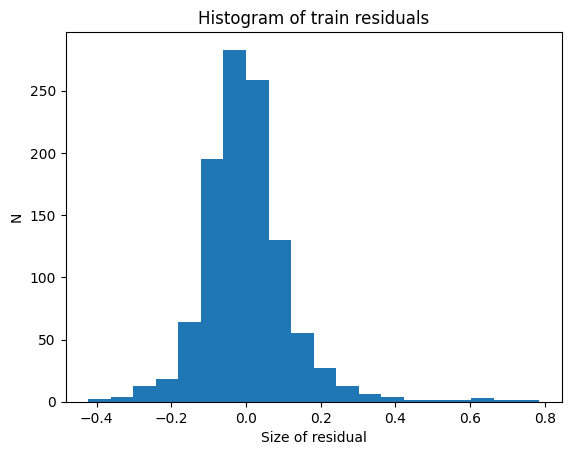

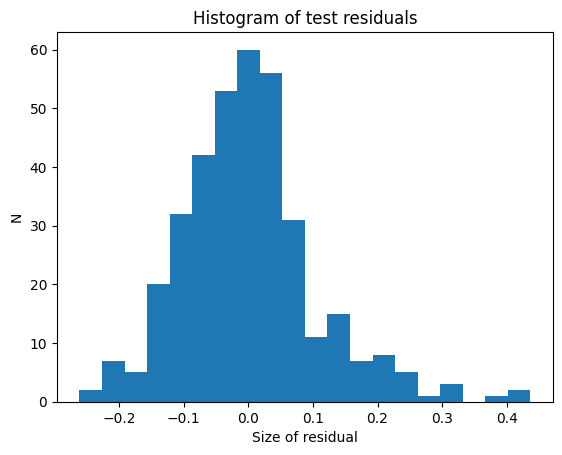

In [17]:
# Plot the lasso's residuals
plt.hist(lasso_train_resids, bins=20)
plt.title("Histogram of train residuals")
plt.xlabel("Size of residual")
plt.ylabel("N")
plt.show()
plt.hist(lasso_test_resids, bins=20)
plt.title("Histogram of test residuals")
plt.xlabel("Size of residual")
plt.ylabel("N")
plt.show()

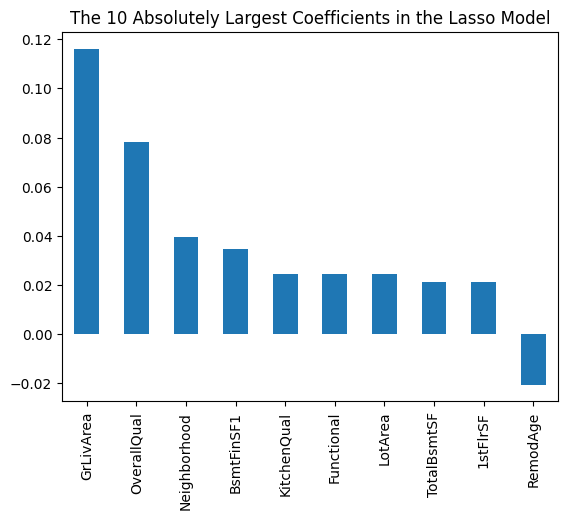

In [18]:
# Show the 10 most important features in the lasso estimator
lasso_coefs = pd.Series(best_lasso_estimator["lasso"].coef_, index=all_cols)
sorted_index = lasso_coefs.abs().sort_values(ascending=False).index
lasso_coefs.loc[sorted_index[:10]].plot(kind="bar")
plt.title("The 10 Absolutely Largest Coefficients in the Lasso Model")
plt.show()

In [19]:
###### Export Kaggle Submission ######
# Export Kaggle test predictions for upload (.csv)
# Define little helper function for that end
def export_kaggle_submission(estimator, file_name):
    kaggle_test_preds = estimator.predict(test)
    kaggle_test_preds = np.exp(kaggle_test_preds)  # re-convert
    kaggle_test_preds = pd.DataFrame(
        kaggle_test_preds, index=test.index, columns=["SalePrice"]
    )
    kaggle_test_preds.to_csv(file_name + ".csv", index=True)


export_kaggle_submission(best_lasso_estimator, "submission_lasso")

This model performs quite well with an R squared of over 0.9 on the test set. Additionally, the required regularization for the lasso model is low with an alpha of around 0.004.

On Kaggle this simple model scored with an RMSE of around 0.134, which is in line with my CV results. This landed me in the first third of the leaderboard when I made the submission.

### XGBoost Regression <a class="anchor" id="XGB"></a>

I'd like to try out XGBoost on the data, too, and see how well that estimator performs.

Here, I would have liked to use the parameter *early_stopping_rounds* but that currently is not possible when using scikit-learn's GridSearchCV. I would have to expand some parts of XGBRegressor...

In [20]:
###### XGBoost ######
# Init the XGB Regresssor
# (scikit-learn api)
xgb_regressor = XGBRegressor(
    objective="reg:squarederror",
    booster="gbtree",
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    grow_policy="lossguide",
    tree_method="hist",
    reg_lambda=0,
    max_bin=256,
    n_jobs=4,
)

# Use the same preprocessor as before
xgb_pipe = Pipeline([("preprocessor", preprocessor), ("xgb_regressor", xgb_regressor)])

# Re-init the kfold object
kfold = KFold(shuffle=True, random_state=11)

# Init the param grid
params = {
    "xgb_regressor__reg_alpha": [0.01, 0.1],
    "xgb_regressor__subsample": [0.5, 0.55],
    "xgb_regressor__colsample_bytree": [0.5, 0.55],
    "preprocessor__categorical__target_encoder__smoothing": [None, 10, 20],
}

# Init and run GridSearcher
gridCV = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get the best estimator and parameters
best_xgb_estimator = gridCV.best_estimator_
best_xgb_params = gridCV.best_params_

In [21]:
# Print XGBoost results
print("XGB: Optimized reg_alpha:")
print(best_xgb_params["xgb_regressor__reg_alpha"])
print("XGB: Optimized smoothing of target encoder")
print(best_xgb_params["preprocessor__categorical__target_encoder__smoothing"])
print()
xgb_train_resids, xgb_test_resids = print_scores(best_xgb_estimator, "XGB")

XGB: Optimized reg_alpha:
0.1
XGB: Optimized smoothing of target encoder
None

XGB: Best CV RMSE (average):
0.12581918887196214

XGB: Train RMSE:
0.010877610168526354
XGB: Train R squared:
0.9992292857205156

XGB: Test RMSE:
0.10648405565023947
XGB: Test R squared:
0.9296135137824019


In [22]:
# Export Kaggle test predictions for upload (.csv)
export_kaggle_submission(best_xgb_estimator, "submission_xgb")

The XGBRegressor performs comparatively as well as the Lasso model while it clearly overfits on the train data - which is normal for boosting. This is also confirmed by the respective Kaggle submission, which got me a higher RMSE than the Lasso estimator.

Mostly I was interested in seeing if XGBoost's base trees can exploit any non-linear relationships in the data. However, from my submission it looks like here we cannot trump a linear model by boosting trees.

### AdaBoost Regression <a class="anchor" id="AdaBoost"></a>

In comparison to XGBoost, let's also try out sklearn's AdaBoostRegressor.

In [23]:
###### AdaBoost ######
# Init the base estimator
tree_regressor = DecisionTreeRegressor(max_depth=10)

# Init the AdaBoost regressor
ada = AdaBoostRegressor(
    base_estimator=tree_regressor,
    learning_rate=1,
    loss="exponential",
    random_state=10,
)

# Re-use preprocessor for pipeline
ada_pipe = Pipeline([("preprocessor", preprocessor), ("ada", ada)])

# Re-init the kfold object
kfold = KFold(shuffle=True, random_state=11)

# Init param grid
params = {
    "ada__n_estimators": [100, 150, 200],
    "preprocessor__categorical__target_encoder__smoothing": [None, 5],
}

# Init and run GridSearcher
gridCV = GridSearchCV(
    estimator=ada_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
    # n_jobs=-1,  # Gives tons of non-catchable warnings
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get the best estimator and parameters
best_ada_estimator = gridCV.best_estimator_
best_ada_params = gridCV.best_params_

In [24]:
# Print AdaBoost results
print("AdaBoost: Optimized n_estimators:")
print(best_ada_params["ada__n_estimators"])
print("AdaBoost: Optimized smoothing of target encoder")
print(best_ada_params["preprocessor__categorical__target_encoder__smoothing"])
print()
ada_train_resids, ada_test_resids = print_scores(best_ada_estimator, "AdaBoost")

AdaBoost: Optimized n_estimators:
150
AdaBoost: Optimized smoothing of target encoder
None

AdaBoost: Best CV RMSE (average):
0.1411499400516881

AdaBoost: Train RMSE:
0.017082752615204994
AdaBoost: Train R squared:
0.9980991750326885

AdaBoost: Test RMSE:
0.12946207649794936
AdaBoost: Test R squared:
0.8959588234154697


While AdaBoost performs quiet decently, it is not able catch up with XGBoost's results.

### Linear Support Vector Regressor <a class="anchor" id="SVR"></a>

Another linear model. Using a polynomial kernel (and RBF kernel) earned me a very bad RMSE on Kaggle. That is why I decided to stick with a linear kernel. Interestingly though, the non-linear kernels showed a rather good performance on the local test data.

In [25]:
###### Linear SVR ######
# Init the linear support vector regressor
svr = LinearSVR(
    tol=1e-4, dual=False, loss="squared_epsilon_insensitive", random_state=7
)

# Re-use preprocessor for pipeline
svr_pipe = Pipeline([("preprocessor", preprocessor), ("svr", svr)])

# Re-init the kfold object
kfold = KFold(shuffle=True, random_state=11)

# Init the param grid
params = {
    "svr__C": [4, 5, 6],  # lower values mean more regularization
    "svr__epsilon": [0, 1],
    "preprocessor__categorical__target_encoder__smoothing": [None, 1, 10],
}

# Init and run GridSearcher
gridCV = GridSearchCV(
    estimator=svr_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
    # n_jobs=-1,  # Gives tons of non-catchable warnings
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get the best estimator and parameters
best_svr_estimator = gridCV.best_estimator_
best_svr_params = gridCV.best_params_

In [26]:
# Print SVR results
print("SVR: Optimized C:")
print(best_svr_params["svr__C"])
print("SVR: Optimized epsilon:")
print(best_svr_params["svr__epsilon"])
print("SVR: Optimized smoothing of target encoder:")
print(best_svr_params["preprocessor__categorical__target_encoder__smoothing"])
print()
svr_train_resids, svr_test_resids = print_scores(best_svr_estimator, "SVR")

SVR: Optimized C:
5
SVR: Optimized epsilon:
0
SVR: Optimized smoothing of target encoder:
None

SVR: Best CV RMSE (average):
0.1305927396589115

SVR: Train RMSE:
0.11127389529435693
SVR: Train R squared:
0.9193483963438027

SVR: Test RMSE:
0.10693045301344119
SVR: Test R squared:
0.9290221350809206


The linear support vector regressor also shows a similar performance to the Lasso model which is not surprising as, well, both models are linear.

### Random Forest Regressor <a class="anchor" id="forest"></a>

In [27]:
###### Random Forest Regressor ######
# Init randdom forest regressor
forest = RandomForestRegressor(
    n_estimators=300,
    criterion="squared_error",
    n_jobs=4,
    random_state=7,
    bootstrap=True,
)

# Re-use preprocessor for pipeline
forest_pipe = Pipeline([("preprocessor", preprocessor), ("forest", forest)])

# Re-init the kfold object
kfold = KFold(shuffle=True, random_state=11)

# Init the param grid
params = {
    "forest__min_samples_leaf": [1, 2, 3, 4],
    "preprocessor__categorical__target_encoder__smoothing": [None, 1, 10],
}

# Init and run GridSearcher
gridCV = GridSearchCV(
    estimator=forest_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
    # n_jobs=-1,  # Gives tons of non-catchable warnings
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get best estimator and parameters
best_forest_estimator = gridCV.best_estimator_
best_forest_params = gridCV.best_params_

In [28]:
# Print forest results
print("Forest: Optimized min_samples_leaf:")
print(best_forest_params["forest__min_samples_leaf"])
print("Forest: Optimized smoothing of target encoder:")
print(best_forest_params["preprocessor__categorical__target_encoder__smoothing"])
print()
forest_train_resids, forest_test_resids = print_scores(best_forest_estimator, "Forest")

Forest: Optimized min_samples_leaf:
2
Forest: Optimized smoothing of target encoder:
None

Forest: Best CV RMSE (average):
0.140951764404815

Forest: Train RMSE:
0.061926617872167904
Forest: Train R squared:
0.975020649166026

Forest: Test RMSE:
0.12778745454061047
Forest: Test R squared:
0.8986330086762676


Like the XGBoost and AdaBoost regressors, the random forest regressor overfits on the train set. Interestingly, the random forest regressor performs slightly better than AdaBoost.

### K Neighbors Regressor <a class="anchor" id="KNR"></a>

In [29]:
###### K Neighbors Regressor ######
# Init k nearest neighbors regressor
knr = KNeighborsRegressor()

# Re-use preprocessor for pipeline
knr_pipe = Pipeline([("preprocessor", preprocessor), ("knr", knr)])

# Re-init the kfold object
kfold = KFold(shuffle=True, random_state=11)

# Init the param grid
params = {
    "knr__n_neighbors": np.arange(10, 16, 1),
    "knr__weights": ["uniform", "distance"],
    "preprocessor__categorical__target_encoder__smoothing": [None, 1, 10],
}

# Init and run GridSearcher
gridCV = GridSearchCV(
    knr_pipe,
    param_grid=params,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    refit=True,
    # n_jobs=-1,  # Gives tons of non-catchable warnings
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridCV.fit(X_train, y_train)

# Get the best estimator and parameters
best_knr_estimator = gridCV.best_estimator_
best_knr_params = gridCV.best_params_

In [30]:
# Print KNR results
print("KNR: Optimized n_neighbors:")
print(best_knr_params["knr__n_neighbors"])
print("KNR: Optimized smoothing of target encoder")
print(best_knr_params["preprocessor__categorical__target_encoder__smoothing"])
print()
knr_train_resids, knr_test_resids = print_scores(best_knr_estimator, "KNR")

KNR: Optimized n_neighbors:
14
KNR: Optimized smoothing of target encoder
1

KNR: Best CV RMSE (average):
0.18082453916983782

KNR: Train RMSE:
3.358137563841092e-08
KNR: Train R squared:
0.9999999999999927

KNR: Test RMSE:
0.16736566360771177
KNR: Test R squared:
0.8261187132222048


The k nearest neighbors model is the one that performs the worst on the test set while overfitting the most.

## Model Stacking <a class="anchor" id="model_stacking"></a>

Analysis of the test residuals reveals the following:

(a) Besides the KNR model, all esimators' residuals seem to have a mean of zero (according to the standard one-sided t-test at the 5% level). The mean of AdaBoost's residuals lies on the 10% significance margin (p-value of 0.096).

(c) While the histograms might suggest that the residuals are normally distributed, the Shapiro-Wilk test clearly rejects the hypothesis of normally distributed residuals for all models.

(b) The rediduals accross the different estimators seem to be strongly correlated but not perfectly.

In [31]:
# Define a simple t-tester
def one_sample_t_test(x, h0=0, two_sided=False):
    std_x = np.std(x, ddof=1)
    mean_x = np.mean(x)
    t_stat = np.sqrt(len(x)) * (mean_x - h0) / std_x
    p_value = stats.t.cdf(t_stat, df=len(x) - 1)
    p_value = min([p_value, 1 - p_value])
    if two_sided:
        p_value = 2 * p_value
    return p_value


# Print the t-test results for the test residuals
# given that H0: E(e) = 0
model_names = ["Lasso", "XGB", "AdaB", "SVR", "Forest", "KNR"]
test_resids = [
    lasso_test_resids,
    xgb_test_resids,
    ada_test_resids,
    svr_test_resids,
    forest_test_resids,
    knr_test_resids,
]

for name, resids in zip(model_names, test_resids):
    _, shapiro_p_value = stats.shapiro(resids)
    print("{}: P-value of t-test for test residuals:".format(name))
    print(one_sample_t_test(resids))
    print("{}: P-value of Shapiro-Wilk test for test residuals".format(name))
    print(shapiro_p_value)
    print("\n")

Lasso: P-value of t-test for test residuals:
0.44395064773223025
Lasso: P-value of Shapiro-Wilk test for test residuals
2.5931550240443357e-08


XGB: P-value of t-test for test residuals:
0.2301277093592235
XGB: P-value of Shapiro-Wilk test for test residuals
1.3472696991811972e-05


AdaB: P-value of t-test for test residuals:
0.0958812125710149
AdaB: P-value of Shapiro-Wilk test for test residuals
2.855403359505043e-13


SVR: P-value of t-test for test residuals:
0.42328068283059245
SVR: P-value of Shapiro-Wilk test for test residuals
1.1994151805083675e-07


Forest: P-value of t-test for test residuals:
0.190133302957477
Forest: P-value of Shapiro-Wilk test for test residuals
2.7620062487132557e-11


KNR: P-value of t-test for test residuals:
0.0423926276963719
KNR: P-value of Shapiro-Wilk test for test residuals
8.713135074556178e-11




Pairplot of test residuals:


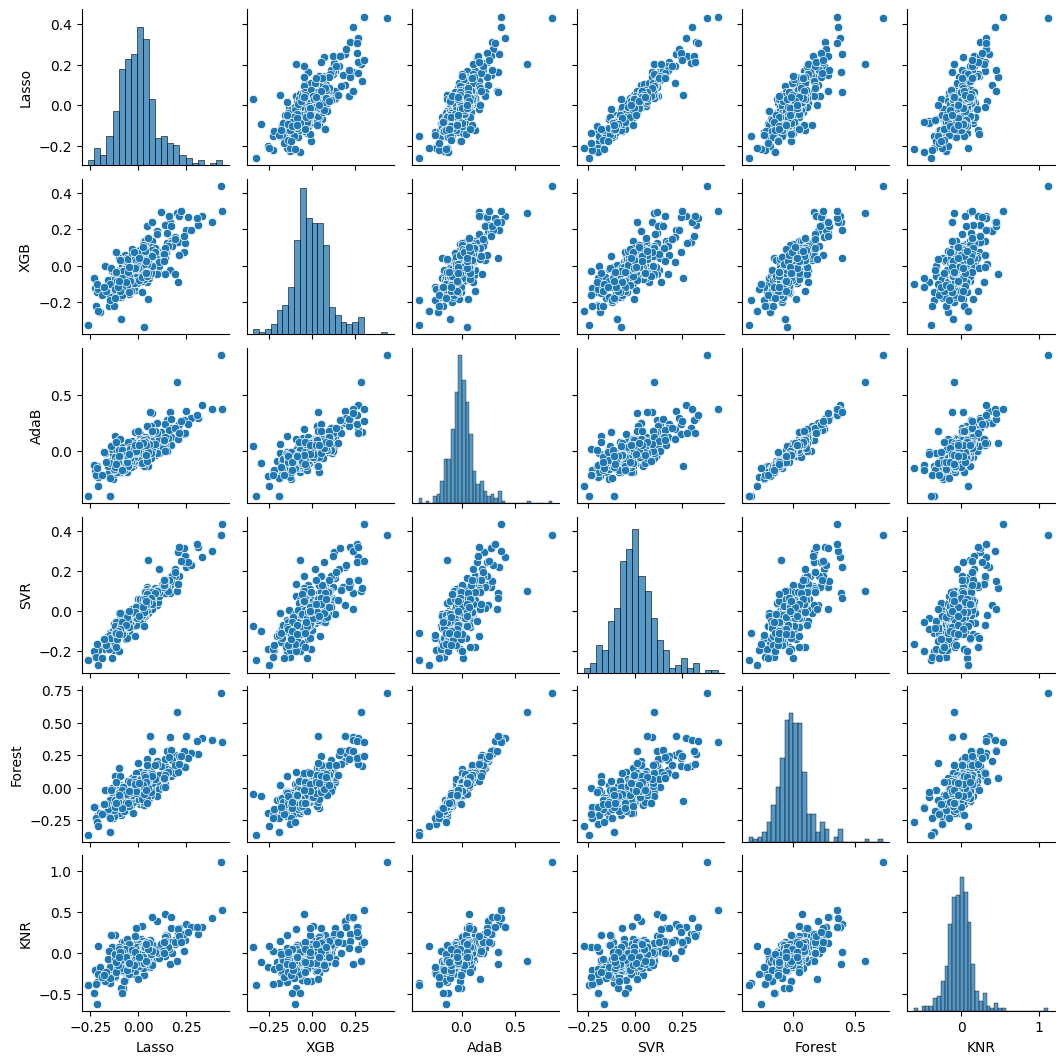

Test residuals: Correlation matrix:


,Lasso,XGB,AdaB,SVR,Forest,KNR
Lasso,1.00,0.76,0.78,0.95,0.81,0.69
XGB,,1.00,0.79,0.75,0.81,0.55
AdaB,,,1.00,0.70,0.97,0.66
SVR,,,,1.00,0.74,0.60
Forest,,,,,1.00,0.65
KNR,,,,,,1.00


In [32]:
# Collect test residuals in a data frame
test_resids = pd.concat(test_resids, axis=1)
test_resids.columns = model_names

# Show a pair plot of the residuals
print("Pairplot of test residuals:")
ax = sns.pairplot(data=test_resids, height=1.8)
plt.show()

# Print the correlation coefficients
test_resids_corr = test_resids.corr().round(2)
for i in range(len(test_resids_corr)):
    for j in range(0, i):
        test_resids_corr.iloc[i, j] = None

print("Test residuals: Correlation matrix:")
test_resids_corr.style.format(na_rep="", precision=2)

Observation (a) shows us that the four best performing estimators seem to produce unbiased or only slightly biased predictions.

Observation (b) might be caused by structurally non-normal data or by outliers that I have missed out in my analysis. If I apply the Shapiro-Wilk test on the logarithmized labels it will also reject normality. Hence, the first explanation is likely to be true.

Observation (c) suggests that model stacking might bring some improvements, but probably not very significant ones.

As an exercise, I will stack my five estimators in the following using ridge regression as the meta model.

My approach follows [this tutorial](https://mlfromscratch.com/model-stacking-explained/) where the hyperparameter-tuned estimators get re-trained on train-CV-slices of the train data set in order to make predictions on the smaller test-CV-slices. These predictions then get used as features for the meta model. 

For making predictions on the hold-out data (or any other prediction data), my model stacker takes the average of the predictions of the CV trained models.

I try out ridge regression as the meta model. This follows scikit-learn's StackingRegressor's default.

In [33]:
# Collect the models
models = [
    ("Lasso", best_lasso_estimator),
    ("XGB", best_xgb_estimator),
    ("AdaB", best_ada_estimator),
    ("SVR", best_svr_estimator),
    ("Forest", best_forest_estimator),
    ("KNR", best_knr_estimator),
]

# Define the meta model
meta_ridge_cv = RidgeCV()

# Init the model stacker
model_stacker = tools.tools.ModelStacker(
    models=models,
    meta_model=meta_ridge_cv,
    n_splits=5,
    shuffle=True,
    random_state=10,
    poly_degree=None,
    passthrough=False,
)

# Fit the train data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_stacker.fit(X_train, y_train)

# Make predictions on the train and test data
stacker_train_preds = model_stacker.predict(X_train)
stacker_test_preds = model_stacker.predict(X_test)

# Print the meta model's scores
print("Stacked models: Train RMSE:")
print(mean_squared_error(y_train, stacker_train_preds, squared=False))
print("Stacked models: Train R squared:")
print(r2_score(y_train, stacker_train_preds))
print()
print("Stacked models: Test RMSE:")
print(mean_squared_error(y_test, stacker_test_preds, squared=False))
print("Stacked models: Test R squared:")
print(r2_score(y_test, stacker_test_preds))

export_kaggle_submission(model_stacker, "submission_model_stacker")

Stacked models: Train RMSE:
0.07061140041265336
Stacked models: Train R squared:
0.9675229873819495

Stacked models: Test RMSE:
0.09916964603731399
Stacked models: Test R squared:
0.9389511279829285


Model stacking improved the predictions slightly on the local test set and lowered my RMSE on the Kaggle test set to 0.128. An RMSE on the lokal test set of around 0.1 is fairly decent. However, it is possible to do even better as the leaderboard shows.

## Experimental and Non-Finished: Regression Using a Neuronal Network <a class="anchor" id="neuronal_network"></a>

**Work in progress...**

As I have made good experiences with neuronal networks in other contexts, I also want to assess their power in the current environment.

For fitting a NN I do not intend to do any cross validation and hyperparameter tuning. Hence, I apply all final preprocessing steps beforehand.

The architecture of the network is still not final.

As I want to include a validation set during fitting, I redo the train data splitting from above:

In [18]:
import tensorflow as tf
from tensorflow import keras

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=200, shuffle=True, random_state=7
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=200, shuffle=False
)

# Apply preprocessing
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_train = preprocessor.fit_transform(X_train, y_train)
    X_test = preprocessor.transform(X_test)
    X_val = preprocessor.transform(X_val)

In [24]:
def generate_dataset(data, labels, shuffle=False, batch_size=128, repeat=True):
    data, labels = data.copy(), labels.copy()
    ds = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))
    if repeat:
        ds = ds.repeat()
    if batch_size is not None:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = generate_dataset(X_train, y_train)
test_ds = generate_dataset(X_test, y_test, batch_size=200)
val_ds = generate_dataset(X_val, y_val, batch_size=200)

In [68]:
# Built the network
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],), dtype='float64'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss=keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                5184      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Train the model
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    x=train_ds,
    epochs=20,
    steps_per_epoch=2048, # 256 times the whole data
    validation_data=val_ds,
    validation_steps=1,
    callbacks=[early_stopping_callback],
    use_multiprocessing=True,
)

Epoch 1/20
2048/2048 [==============================] - 6s 3ms/step - loss: 2.1639 - root_mean_squared_error: 1.4710 - val_loss: 0.6968 - val_root_mean_squared_error: 0.8347
Epoch 2/20
2048/2048 [==============================] - 5s 2ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.6966 - val_root_mean_squared_error: 0.8346
Epoch 3/20
2048/2048 [==============================] - 5s 2ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.7100 - val_root_mean_squared_error: 0.8426
Epoch 4/20
2048/2048 [==============================] - 5s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.6711 - val_root_mean_squared_error: 0.8192
Epoch 5/20
2048/2048 [==============================] - 5s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.6465 - val_root_mean_squared_error: 0.8041
Epoch 6/20
2048/2048 [==============================] - 5s 2ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0

The model's generalization power is just abysmal :-(

In [73]:
# Make predictions on the train and test data
train_preds = model(X_train).numpy()
test_preds = model(X_test).numpy()

# Print scores
print("Neuronal Net: Train RMSE:")
print(mean_squared_error(train_preds, y_train, squared=False))
print("Neuronal Net: Train R squared:")
print(r2_score(train_preds, y_train))
print("Neuronal Net: Test RMSE:")
print(mean_squared_error(test_preds, y_test, squared=False))
print("Neuronal Net: Test R squared:")
print(r2_score(test_preds, y_test))

Neuronal Net: Train RMSE:
0.04235363106366268
Neuronal Net: Train R squared:
0.9869180397873769
Neuronal Net: Test RMSE:
0.7877175064106096
Neuronal Net: Test R squared:
0.1812312096816805
